# Storing Computed Data and Figures

Much of the data and plots computed with scqubits can easily be stored in memory, or exported and written to files. Data that we may want to save includes 

* computed eigenvalues and eigenvectors, 
* qubit parameters,
* matrix elements,
* parameter sweeps, and
* plots,

to name a few. Further, scqubits makes it possible to write the configuration of a qubit or a `HilbertSpace` object to disk, and recreate the object instance later on. The following subsections illustrate usage the different usage cases.


## Storing qubit spectral data in memory
Consider an instance of a transmon qubit:

In [33]:
import numpy as np
import scqubits as scq

tmon = scq.Transmon(
    EJ=15.0, 
    EC=0.3, 
    ng=0.0,
    ncut=30
)

As usual, we may obtain eigenvalues and eigenvectors via `tmon.eigensys()`, returned as two numpy arrays:  

In [11]:
evals, evecs = tmon.eigensys(evals_count=4)
print(evals)

[-12.07703386  -6.39445819  -1.05664942   3.89594699]


Alternatively, we can choose to store the results in a `SpectrumData` object by setting the optional keyword argument `return_spectrumdata`:

In [14]:
specdata = tmon.eigensys(evals_count=4, return_spectrumdata=True)
specdata

The relevant data is accessible through the attributes `.energy_table`, `.state_table`. The system parameters used to generate the data is stored alongside under `.system_params`.

In [17]:
specdata.energy_table

array([-12.07703386,  -6.39445819,  -1.05664942,   3.89594699])

In [20]:
specdata.system_params

{'EJ': 15.0, 'EC': 0.3, 'ng': 0.0, 'ncut': 30, 'truncated_dim': None}

In a similar manner, matrix elements can be stored in a `DataStore` object, accessible via the attribute `.matrixelem_table`:

In [27]:
m_stored = tmon.matrixelement_table(operator='n_operator', return_datastore=True)
m_stored.matrixelem_table

array([[-1.94289029e-16, -1.08780080e+00,  9.71445147e-17,
        -3.95057287e-02,  0.00000000e+00,  3.24570806e-03],
       [-1.08780080e+00,  5.55111512e-17,  1.49027312e+00,
        -2.22044605e-16, -8.66090220e-02, -4.16333634e-17],
       [ 9.71445147e-17,  1.49027312e+00, -5.55111512e-17,
         1.75524483e+00,  0.00000000e+00, -1.51360095e-01],
       [-3.95057287e-02, -2.22044605e-16,  1.75524483e+00,
        -1.66533454e-16, -1.92581364e+00,  5.55111512e-17],
       [ 0.00000000e+00, -8.66090220e-02,  0.00000000e+00,
        -1.92581364e+00, -2.22044605e-16,  1.95455333e+00],
       [ 3.24570806e-03, -5.55111512e-17, -1.51360095e-01,
         1.66533454e-16,  1.95455333e+00, -1.94289029e-16]])

Finally, scans of qubit spectral data over a set of parameter values are automatically returned in the form of `SpectrumData` objects. Again, data is accessible through the attributes mentioned above:

In [31]:
spec_scan = tmon.get_spectrum_vs_paramvals(param_name='ng', param_vals=np.linspace(0, 1, 10))
spec_scan.energy_table[0:2]

array([[-12.07703386,  -6.39445819,  -1.05664942,   3.89594699,
          8.34157217,  12.54032139],
       [-12.07703384,  -6.39445956,  -1.0566065 ,   3.89515784,
          8.35028668,  12.4619384 ]])


## Writing qubit spectral data to disk, and reading back from file
`SpectrumData` objects can easily be written to an `.h5` file and read back from disk:

In [32]:
specdata.filewrite('test.h5')
new_specdata = scq.read('test.h5')

new_specdata.energy_table

array([-12.07703386,  -6.39445819,  -1.05664942,   3.89594699])

Note: as a convenient shortcut for *directly* writing to file, many methods accept `filename` as an optional argument:

``tmon.eigensys(evals_count=4, filename='test.h5')``


## Writing a qubit instance to disk, and recreating it from file
Once a qubit is initialized, it may be useful to save it to file and recreate it later. This is possible for all qubit classes, and stores all circuit parameters and other metadata to create an identical copy of the current qubit configuration.

For the `Transmon` instance used above, this works as follows:

In [35]:
tmon.filewrite('my_tmon.h5')

new_tmon = scq.read('my_tmon.h5')

Indeed, `new_tmon` is now a new `Transmon` instance with the same parameters as `tmon`:

In [36]:
new_tmon

Transmon(**{'EJ': 15.0, 'EC': 0.3, 'ng': 0.0, 'ncut': 30, 'truncated_dim': None})

## Summary of classes enabling file input/output
A variety of class instances can be saved to disk via

    <class>.filewrite(<filename>)

and read back by

    scq.read(<filename>)

when using the `.h5` file format. (CSV file format only supports a small subset of the functionality.)


The following table lists the classes that support file input and output,


|  class              |   purpose                                                                  |
|---------------------|----------------------------------------------------------------------------|
| `SpectrumData`      | storage of eigenvalues, eigenvectors, and relevant metadata                |
| `DataStore`         | storage of matrix elements or coherence data (and general purpose storage) |
| `HilbertSpace`      | stores data needed for recreating object instance                          |
| `ParameterSweep`*   | stores data needed for recreating object instance                          |
| `Transmon`          | stores data needed for recreating object instance                          |
| `TunableTransmon`   | stores data needed for recreating object instance                          |
| `Fluxonium`         | stores data needed for recreating object instance                          |
| `FluxQubit`         | stores data needed for recreating object instance                          |
| `ZeroPi`            | stores data needed for recreating object instance                          |
| `FullZeroPi`        | stores data needed for recreating object instance                          |


Data stored to `.h5` files includes information about the type of object stored. Upon reading, the same type of object
is recreated and returned by the ``read(...)`` function.

``ParameterSweep`` forms an exception: the returned object
is of type ``StoredSweep`` rather than ``ParameterSweep``. It can be called to perform spectrum lookups, produce plots
from sweep spectral data etc., but it does not support updates with new parameters. For that, a new ``ParameterSweep``
object can be created by using ::

   <StoredSweep>.new_sweep(subsys_update_list, update_hilbertspace)

    
## Exporting plots to file
All plotting routines in scqubits can be called with a keyword argument ``filename='output.pdf'``. This will generate
the plot, display it, and in addition write it to the specified file. The output format is determined by the file suffix
provided in the filename. A variety of output formats is supported via Matplotlib, including pdf, jpg, png, svg.
    
Example:


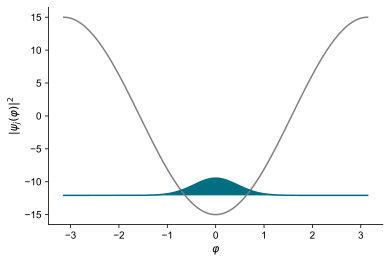

In [41]:
tmon.plot_phi_wavefunction(filename='wavefunc.pdf');